 ## Đồ án cuối kỳ môn Xử lý ngôn ngữ tự nhiên - 841448
 ##### Tên sinh viên: Huỳnh Phúc Hưng  MSSV: 3122411073




Cell 1: Mount Google Drive

In [ ]:
# Cell 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cell 2: Tạo thư mục lưu mô hình

In [3]:
import os

PROJECT_DIR = "/content/drive/MyDrive/NLP_project"
os.makedirs(PROJECT_DIR, exist_ok=True)

BEST_MODEL_PATH = os.path.join(PROJECT_DIR, "best_model.pth")
print("Checkpoint sẽ được lưu tại:", BEST_MODEL_PATH)

Checkpoint sẽ được lưu tại: /content/drive/MyDrive/NLP_project/best_model.pth


Cell 3: Import & Setup

In [ ]:
import sys
import time
import random
import math
from collections import Counter
import gzip

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Cài và load Spacy + NLTK cho tokenization & BLEU
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

import spacy
spacy_en = spacy.load("en_core_web_sm")
spacy_fr = spacy.load("fr_core_news_sm")

import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
smooth_fn = SmoothingFunction().method3

Using device: cuda
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 116.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 59.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Cell 4: Đọc dữ liệu từ các file .gz trong Drive

In [ ]:
!ls /content/drive/MyDrive/NLP_project

best_model.pth	test.fr.gz   train.fr.gz  val.fr.gz
test.en.gz	train.en.gz  val.en.gz


In [4]:
# Cell 4: Đọc dữ liệu từ các file .gz trong Drive
import gzip

# Đường dẫn tới các file .gz
train_en_path = os.path.join(PROJECT_DIR, "train.en.gz")
train_fr_path = os.path.join(PROJECT_DIR, "train.fr.gz")
val_en_path   = os.path.join(PROJECT_DIR, "val.en.gz")
val_fr_path   = os.path.join(PROJECT_DIR, "val.fr.gz")
test_en_path  = os.path.join(PROJECT_DIR, "test.en.gz")
test_fr_path  = os.path.join(PROJECT_DIR, "test.fr.gz")

def read_parallel_gz(en_gz, fr_gz, max_sentences=None):
    with gzip.open(en_gz, 'rt', encoding='utf-8') as f_en, gzip.open(fr_gz, 'rt', encoding='utf-8') as f_fr:
        en_lines = f_en.readlines()
        fr_lines = f_fr.readlines()
    if max_sentences is not None:
        en_lines = en_lines[:max_sentences]
        fr_lines = fr_lines[:max_sentences]
    assert len(en_lines) == len(fr_lines), "Số dòng en/fr không khớp"
    return list(zip(en_lines, fr_lines))

# Đọc dữ liệu
train_data = read_parallel_gz(train_en_path, train_fr_path, max_sentences=None)
valid_data = read_parallel_gz(val_en_path,   val_fr_path,   max_sentences=None)
test_data  = read_parallel_gz(test_en_path,  test_fr_path,  max_sentences=None)

print(f"Train: {len(train_data)} | Val: {len(valid_data)} | Test: {len(test_data)}")

Train: 29000 | Val: 1014 | Test: 1071


Đã lấy độ dài của 29000 câu.


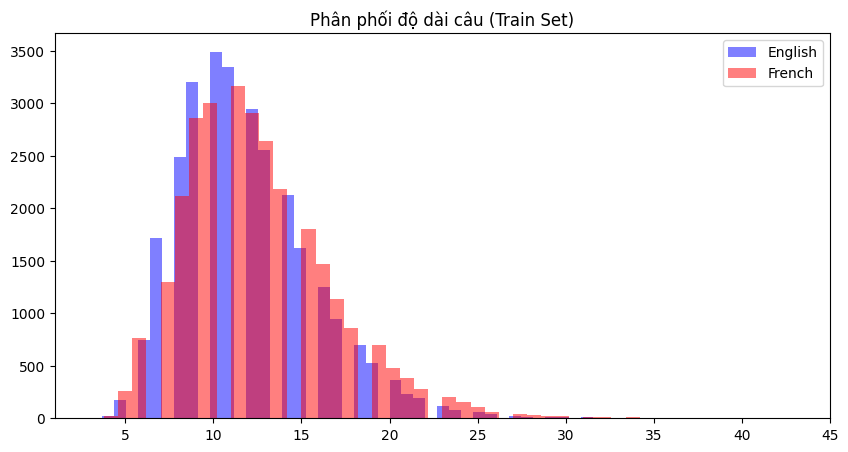

In [5]:
import matplotlib.pyplot as plt

# Kiểm tra xem train_data đã có chưa, nếu chưa thì báo lỗi dễ hiểu
try:
    if 'train_data' not in globals():
        print("LỖI:chưa chạy Cell load dữ liệu. Hãy chạy Cell đó trước!")
    else:
        # Lấy độ dài câu (tách từ đơn giản bằng khoảng trắng)
        en_lens = [len(str(pair[0]).split()) for pair in train_data]
        fr_lens = [len(str(pair[1]).split()) for pair in train_data]

        print(f"Đã lấy độ dài của {len(en_lens)} câu.")

        # Vẽ biểu đồ
        plt.figure(figsize=(10, 5))
        plt.hist(en_lens, bins=50, alpha=0.5, label='English', color='blue')
        plt.hist(fr_lens, bins=50, alpha=0.5, label='French', color='red')
        plt.legend()
        plt.title('Phân phối độ dài câu (Train Set)')
        plt.show()

except Exception as e:
    print(f"Có lỗi xảy ra: {e}")

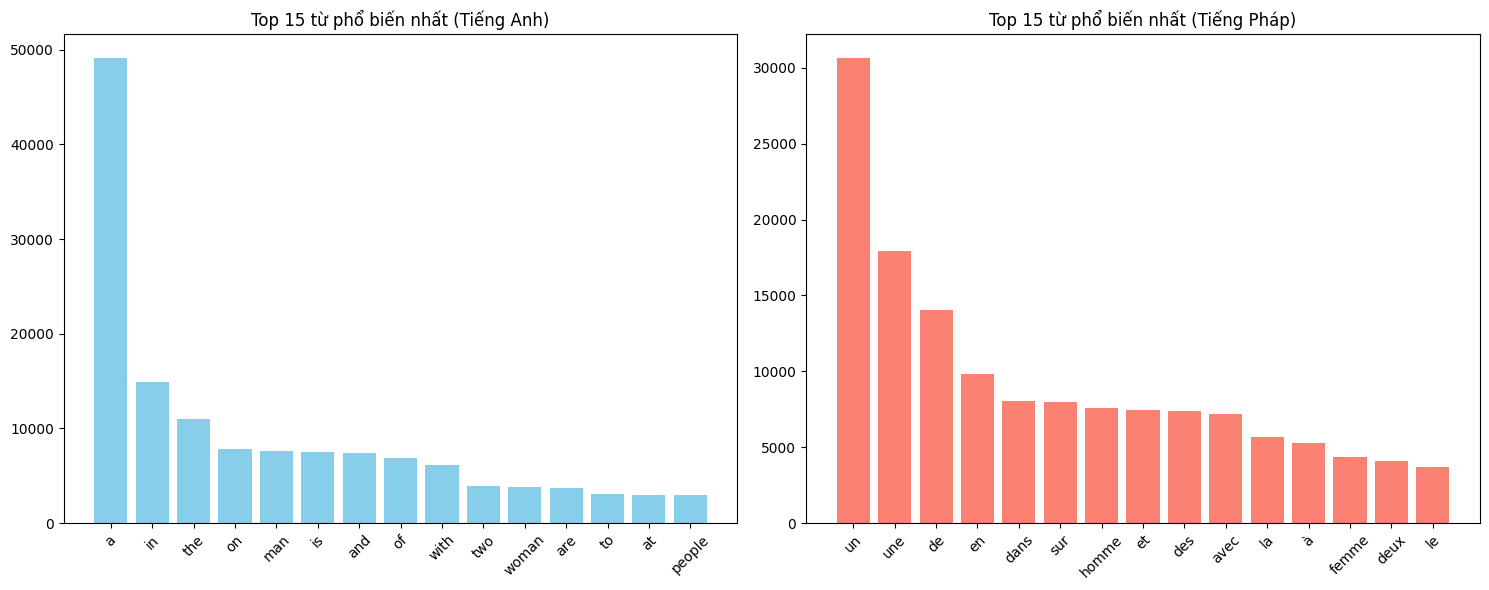

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


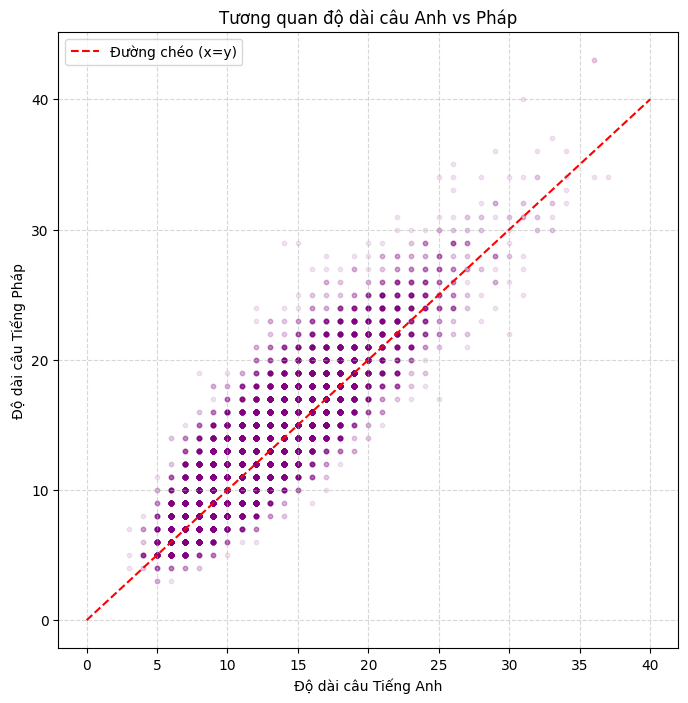

In [13]:
import matplotlib.pyplot as plt
from collections import Counter

# 1. Lấy dữ liệu độ dài (dùng lại code cũ nếu đã chạy, hoặc chạy lại cho chắc)
en_lens = [len(str(pair[0]).split()) for pair in train_data]
fr_lens = [len(str(pair[1]).split()) for pair in train_data]

# 2. Lấy dữ liệu từ vựng (Top words)
# Gom tất cả các câu lại thành 1 chuỗi lớn rồi đếm
all_en_words = " ".join([str(pair[0]) for pair in train_data]).lower().split()
all_fr_words = " ".join([str(pair[1]) for pair in train_data]).lower().split()

en_counter = Counter(all_en_words)
fr_counter = Counter(all_fr_words)

top_n = 15
en_common = en_counter.most_common(top_n)
fr_common = fr_counter.most_common(top_n)

# --- VẼ HÌNH 2.2: BAR CHART (Top Words) ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Tiếng Anh
words, counts = zip(*en_common)
ax1.bar(words, counts, color='skyblue')
ax1.set_title(f'Top {top_n} từ phổ biến nhất (Tiếng Anh)')
ax1.tick_params(axis='x', rotation=45)

# Tiếng Pháp
words, counts = zip(*fr_common)
ax2.bar(words, counts, color='salmon')
ax2.set_title(f'Top {top_n} từ phổ biến nhất (Tiếng Pháp)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
# --- VẼ HÌNH 2.3: SCATTER PLOT (Tương quan) ---
plt.figure(figsize=(8, 8))
plt.scatter(en_lens, fr_lens, alpha=0.1, color='purple', s=10) # alpha thấp để thấy mật độ
plt.plot([0, 40], [0, 40], 'r--', label='Đường chéo (x=y)') # Đường tham chiếu
plt.title('Tương quan độ dài câu Anh vs Pháp')
plt.xlabel('Độ dài câu Tiếng Anh')
plt.ylabel('Độ dài câu Tiếng Pháp')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Cell 5: Tokenizer & Vocabulary

In [ ]:
# Cell 5: Tokenizer & Vocabulary
import spacy
from collections import Counter

# Tokenizers với spacy
spacy_en = spacy.load("en_core_web_sm")
spacy_fr = spacy.load("fr_core_news_sm")

def en_tokenizer(text):
    return [tok.text.lower() for tok in spacy_en.tokenizer(text.strip())]

def fr_tokenizer(text):
    return [tok.text.lower() for tok in spacy_fr.tokenizer(text.strip())]

# Các token đặc biệt
SPECIALS = ["<unk>", "<pad>", "<sos>", "<eos>"]
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3

def build_vocab(lines, tokenizer, max_size=10000):
    counter = Counter()
    for ln in lines:
        counter.update(tokenizer(ln))
    vocab = {tok: idx for idx, tok in enumerate(SPECIALS)}
    next_idx = len(vocab)
    for word, freq in counter.most_common(max_size):
        if word not in vocab:
            vocab[word] = next_idx
            next_idx += 1
    return vocab

# Xây vocab từ tập train
en_vocab = build_vocab([en for en, fr in train_data], en_tokenizer, max_size=10000)
fr_vocab = build_vocab([fr for en, fr in train_data], fr_tokenizer, max_size=10000)

print("English vocab size:", len(en_vocab))
print("French  vocab size:", len(fr_vocab))

English vocab size: 9797
French  vocab size: 10004


Cell 6: Numericalize, Collate, DataLoader

In [ ]:
# Cell 6: Numericalize, Collate, DataLoader

def numericalize(text, tokenizer, vocab):
    # Thêm <sos> và <eos>
    ids = [SOS_IDX]
    for tok in tokenizer(text):
        ids.append(vocab.get(tok, UNK_IDX))
    ids.append(EOS_IDX)
    return ids

def collate_fn(batch):
    src_batch, tgt_batch = [], []
    src_lens, tgt_lens = [], []
    for src_text, tgt_text in batch:
        src_ids = numericalize(src_text, en_tokenizer, en_vocab)
        tgt_ids = numericalize(tgt_text, fr_tokenizer, fr_vocab)
        src_t = torch.tensor(src_ids, dtype=torch.long)
        tgt_t = torch.tensor(tgt_ids, dtype=torch.long)
        src_batch.append(src_t)
        tgt_batch.append(tgt_t)
        src_lens.append(len(src_t))
        tgt_lens.append(len(tgt_t))
    src_pad = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_pad = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_pad.to(device), tgt_pad.to(device), src_lens, tgt_lens

BATCH_SIZE = 64  # bạn có thể chỉnh tùy GPU

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
val_loader   = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader  = DataLoader(test_data,  batch_size=BATCH_SIZE, collate_fn=collate_fn)

# Kiểm tra một batch
src_ex, tgt_ex, src_len_ex, tgt_len_ex = next(iter(train_loader))
print("src batch shape:", src_ex.shape, "| tgt batch shape:", tgt_ex.shape)

src batch shape: torch.Size([64, 30]) | tgt batch shape: torch.Size([64, 30])


Cell 7: Encoder–Decoder LSTM Model

In [ ]:
# Cell 7: Encoder–Decoder LSTM Model

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers=2, dropout=0.5, pad_idx=PAD_IDX):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers,
                           dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_len):
        # src: [B, S]
        embedded = self.dropout(self.embedding(src))  # [B, S, E]
        packed = pack_padded_sequence(embedded, src_len, batch_first=True, enforce_sorted=False)
        _, (hidden, cell) = self.rnn(packed)
        # hidden, cell: [n_layers, B, H]
        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers=2, dropout=0.5, pad_idx=PAD_IDX):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=pad_idx)
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers,
                           dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_tok, hidden, cell):
        # input_tok: [B]
        input_tok = input_tok.unsqueeze(1)  # [B, 1]
        embedded = self.dropout(self.embedding(input_tok))  # [B, 1, E]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))  # output: [B, 1, H]
        logits = self.fc_out(output.squeeze(1))  # [B, V]
        return logits, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, teacher_forcing_ratio=0.5):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward(self, src, tgt, src_len, tgt_len):
        batch_size = src.size(0)
        max_tgt_len = tgt.size(1)
        vocab_size = self.decoder.embedding.num_embeddings

        outputs = torch.zeros(batch_size, max_tgt_len, vocab_size, device=self.device)
        hidden, cell = self.encoder(src, src_len)
        input_tok = tgt[:, 0]  # <sos>

        for t in range(1, max_tgt_len):
            logits, hidden, cell = self.decoder(input_tok, hidden, cell)
            outputs[:, t] = logits
            teacher_force = random.random() < self.teacher_forcing_ratio
            top1 = logits.argmax(1)
            input_tok = tgt[:, t] if teacher_force else top1

        return outputs

Cell 8: Khởi tạo mô hình, optimizer, loss

In [ ]:
# Cell 8: Init Model, Optimizer, Loss

INPUT_DIM = len(en_vocab)   # số lượng từ vựng tiếng Anh
OUTPUT_DIM = len(fr_vocab)  # số lượng từ vựng tiếng Pháp
EMB_DIM = 256               # kích thước embedding
HID_DIM = 512               # kích thước hidden LSTM
N_LAYERS = 2                # số layer LSTM
DROPOUT = 0.5
TEACHER_FORCING = 0.5

encoder = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT, pad_idx=PAD_IDX)
decoder = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT, pad_idx=PAD_IDX)
model = Seq2Seq(encoder, decoder, device, teacher_forcing_ratio=TEACHER_FORCING).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

print("Tổng số tham số của mô hình:", sum(p.numel() for p in model.parameters()))

Tổng số tham số của mô hình: 17557524


Cell 9: Train/Validation + Early Stopping

In [ ]:
# Cell 9: Train/Validation + Early Stopping

def train_epoch(model, loader, optimizer, criterion, clip=1.0):
    model.train()
    total_loss = 0.0
    for src, tgt, src_len, tgt_len in loader:
        optimizer.zero_grad()
        output = model(src, tgt, src_len, tgt_len)  # [B, T, V]
        # bỏ bước đầu <sos> khi tính loss
        logits = output[:, 1:].reshape(-1, OUTPUT_DIM)  # [(B*(T-1)), V]
        gold   = tgt[:, 1:].reshape(-1)                 # [(B*(T-1))]
        loss = criterion(logits, gold)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def evaluate_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    for src, tgt, src_len, tgt_len in loader:
        output = model(src, tgt, src_len, tgt_len)
        logits = output[:, 1:].reshape(-1, OUTPUT_DIM)
        gold   = tgt[:, 1:].reshape(-1)
        loss = criterion(logits, gold)
        total_loss += loss.item()
    return total_loss / len(loader)


class EarlyStopper:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def check(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience
# Early stopping class
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None

    def check(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


Cell 10: Inference — hàm translate(sentence)

In [ ]:
# Cell 10: Inference — hàm translate(sentence)
inv_fr_vocab = {idx: tok for tok, idx in fr_vocab.items()}

def detokenize_fr(ids):
    toks = []
    for i in ids:
        if i == EOS_IDX: break
        if i in (SOS_IDX, PAD_IDX): continue
        toks.append(inv_fr_vocab.get(i, "<unk>"))
    return " ".join(toks)

@torch.no_grad()
def translate(sentence, max_len=50):
    model.eval()
    src_ids = numericalize(sentence, en_tokenizer, en_vocab)
    src_t = torch.tensor(src_ids, dtype=torch.long).unsqueeze(0).to(device)
    src_len = [len(src_ids)]
    hidden, cell = model.encoder(src_t, src_len)
    cur_tok = torch.tensor([SOS_IDX], dtype=torch.long, device=device)
    out_ids = []
    for _ in range(max_len):
        logits, hidden, cell = model.decoder(cur_tok, hidden, cell)
        top1 = logits.argmax(1)
        out_ids.append(top1.item())
        if top1.item() == EOS_IDX: break
        cur_tok = top1
    return detokenize_fr(out_ids)

print(translate("a man is riding a bicycle on the street"))

glacière glacière glacière trois nos nos 80 80 panneau mêlée mêlée mêlée caisses américain américain américain américain wakeboard wakeboard travailler fleurie bosquet placés guide guide salle nagent nagent pleut placés chiens construits unisson tennis martini salle à canette martini water canette canette brassards brassards exercice gravité diagrammes exécutant caisses appuis


Cell 11: Training Loop, lưu Best Model, lưu lịch sử loss, BLEU theo epoch

In [ ]:
# Cell 11: Training Loop
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pickle, os

smooth_fn = SmoothingFunction().method3
N_EPOCHS = 20

# Load lại checkpoint nếu có
try:
    model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
    print("Đã load checkpoint:", BEST_MODEL_PATH)
except FileNotFoundError:
    print("Chưa có checkpoint, sẽ train từ đầu")

# Load lại lịch sử nếu có
if os.path.exists("/content/drive/MyDrive/NLP_project/train_history.pkl"):
    with open("/content/drive/MyDrive/NLP_project/train_history.pkl", "rb") as f:
        history = pickle.load(f)
    train_losses = history["train_losses"]
    val_losses   = history["val_losses"]
    bleu_scores  = history["bleu_scores"]
    best_val     = history["best_val"]
    start_epoch  = history["last_epoch"] + 1
    print("Đã load lại lịch sử, tiếp tục từ epoch", start_epoch)
else:
    train_losses, val_losses, bleu_scores = [], [], []
    best_val = float('inf')
    start_epoch = 1
    print("Không có lịch sử, bắt đầu từ epoch 1")

print("Checkpoint sẽ lưu tại:", BEST_MODEL_PATH)

@torch.no_grad()
def bleu_on_test(sample_size=None):
    model.eval()
    pairs = test_data if sample_size is None else test_data[:sample_size]
    scores = []
    for en_line, fr_line in pairs:
        pred_fr = translate(en_line)
        ref = [fr_tokenizer(fr_line)]
        hyp = fr_tokenizer(pred_fr)
        score = sentence_bleu(ref, hyp, smoothing_function=smooth_fn)
        scores.append(score)
    return sum(scores) / len(scores) if scores else 0.0

# Vòng lặp huấn luyện, chạy đủ 20 epoch
for epoch in range(start_epoch, N_EPOCHS + 1):
    start = time.time()

    # Train
    model.train()
    total_loss = 0.0
    for src, tgt, src_len, tgt_len in tqdm(train_loader, desc=f"Epoch {epoch} [Train]", unit="batch"):
        optimizer.zero_grad()
        output = model(src, tgt, src_len, tgt_len)
        logits = output[:, 1:].reshape(-1, OUTPUT_DIM)
        gold   = tgt[:, 1:].reshape(-1)
        loss = criterion(logits, gold)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
    train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for src, tgt, src_len, tgt_len in tqdm(val_loader, desc=f"Epoch {epoch} [Val]", unit="batch"):
            output = model(src, tgt, src_len, tgt_len)
            logits = output[:, 1:].reshape(-1, OUTPUT_DIM)
            gold   = tgt[:, 1:].reshape(-1)
            loss = criterion(logits, gold)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    # Lưu lịch sử
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    mins, secs = divmod(int(time.time() - start), 60)
    print(f"Epoch {epoch:02d} | Time {mins}m {secs}s | Train {train_loss:.3f} | Val {val_loss:.3f}")

    # BLEU sample
    bleu_score = bleu_on_test(sample_size=200)
    bleu_scores.append(bleu_score)
    print(f"BLEU (sample) = {bleu_score:.4f}")

    # Save best
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print("Đã lưu best model")

    # Lưu lịch sử ra file mỗi epoch
    with open("/content/drive/MyDrive/NLP_project/train_history.pkl", "wb") as f:
        pickle.dump({
            "train_losses": train_losses,
            "val_losses": val_losses,
            "bleu_scores": bleu_scores,
            "best_val": best_val,
            "last_epoch": epoch
        }, f)

Đã load checkpoint: /content/drive/MyDrive/NLP_project/best_model.pth
Đã load lại lịch sử, tiếp tục từ epoch 8
Checkpoint sẽ lưu tại: /content/drive/MyDrive/NLP_project/best_model.pth


Epoch 8 [Val]: 100%|██████████| 16/16 [00:00<00:00, 36.42batch/s]


Epoch 08 | Time 0m 55s | Train 1.993 | Val 2.408
BLEU (sample) = 0.1763
Đã lưu best model


Epoch 9 [Val]: 100%|██████████| 16/16 [00:00<00:00, 36.85batch/s]


Epoch 09 | Time 0m 50s | Train 1.919 | Val 2.428
BLEU (sample) = 0.1759


Epoch 10 [Val]: 100%|██████████| 16/16 [00:00<00:00, 37.62batch/s]


Epoch 10 | Time 0m 51s | Train 1.851 | Val 2.508
BLEU (sample) = 0.1770


Epoch 11 [Val]: 100%|██████████| 16/16 [00:00<00:00, 37.66batch/s]


Epoch 11 | Time 0m 51s | Train 1.777 | Val 2.501
BLEU (sample) = 0.1669


Epoch 12 [Val]: 100%|██████████| 16/16 [00:00<00:00, 36.56batch/s]


Epoch 12 | Time 0m 50s | Train 1.739 | Val 2.510
BLEU (sample) = 0.1793


Epoch 13 [Val]: 100%|██████████| 16/16 [00:00<00:00, 36.33batch/s]


Epoch 13 | Time 0m 50s | Train 1.698 | Val 2.436
BLEU (sample) = 0.1757


Epoch 14 [Val]: 100%|██████████| 16/16 [00:00<00:00, 37.07batch/s]


Epoch 14 | Time 0m 50s | Train 1.632 | Val 2.414
BLEU (sample) = 0.1757


Epoch 15 [Val]: 100%|██████████| 16/16 [00:00<00:00, 37.24batch/s]


Epoch 15 | Time 0m 50s | Train 1.584 | Val 2.504
BLEU (sample) = 0.1875


Epoch 16 [Val]: 100%|██████████| 16/16 [00:00<00:00, 36.14batch/s]


Epoch 16 | Time 0m 50s | Train 1.534 | Val 2.408
BLEU (sample) = 0.1810


Epoch 17 [Val]: 100%|██████████| 16/16 [00:00<00:00, 37.20batch/s]


Epoch 17 | Time 0m 50s | Train 1.489 | Val 2.489
BLEU (sample) = 0.1879


Epoch 18 [Val]: 100%|██████████| 16/16 [00:00<00:00, 37.53batch/s]


Epoch 18 | Time 0m 50s | Train 1.466 | Val 2.486
BLEU (sample) = 0.1832


Epoch 19 [Val]: 100%|██████████| 16/16 [00:00<00:00, 36.75batch/s]


Epoch 19 | Time 0m 50s | Train 1.434 | Val 2.507
BLEU (sample) = 0.1845


Epoch 20 [Val]: 100%|██████████| 16/16 [00:00<00:00, 36.20batch/s]


Epoch 20 | Time 0m 50s | Train 1.377 | Val 2.482
BLEU (sample) = 0.1983


Cell 12: Evaluate BLEU on Test Set

In [ ]:
# Cell 12
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
test_bleu = bleu_on_test(sample_size=500)
print(f"BLEU (test, greedy decoding) = {test_bleu:.4f}")

BLEU (test, greedy decoding) = 0.1574


Cell 13: 5 ví dụ dịch + phân tích lỗi

In [ ]:
# Cell 13
import random
examples = random.sample(test_data, 5)
for i, (en_line, fr_line) in enumerate(examples, 1):
    pred = translate(en_line)
    print(f"--- Example {i} ---")
    print("EN :", en_line.strip())
    print("FR (ground truth):", fr_line.strip())
    print("FR (prediction)  :", pred)
    print()

--- Example 1 ---
EN : There is a girl with a basket and pink boots walking in the woods.
FR (ground truth): Il y a une fille avec un panier et des bottes roses se promenant dans les bois.
FR (prediction)  : il y a une fille avec des lunettes et un fille en rose dans la forêt .

--- Example 2 ---
EN : A person on a black and yellow jet ski with boats in the background.
FR (ground truth): Une personne sur un jet-ski jaune et noir avec des bateaux en arrière-plan.
FR (prediction)  : une personne sur une planche noire et jaune avec des taxis en arrière-plan arrière-plan .

--- Example 3 ---
EN : Two deer next to a statue while a dog watches them
FR (ground truth): Deux cerfs à côté d'une statue qui sont observés par un chien.
FR (prediction)  : deux vaches près d' un clôture tandis qu' un chien regarde .

--- Example 4 ---
EN : Two wooden tables with bottles of liquor on top.
FR (ground truth): Deux tables en bois avec des bouteilles de liqueur dessus.
FR (prediction)  : deux lutteurs de 

Cell 14: Vẽ biểu đồ train/val loss

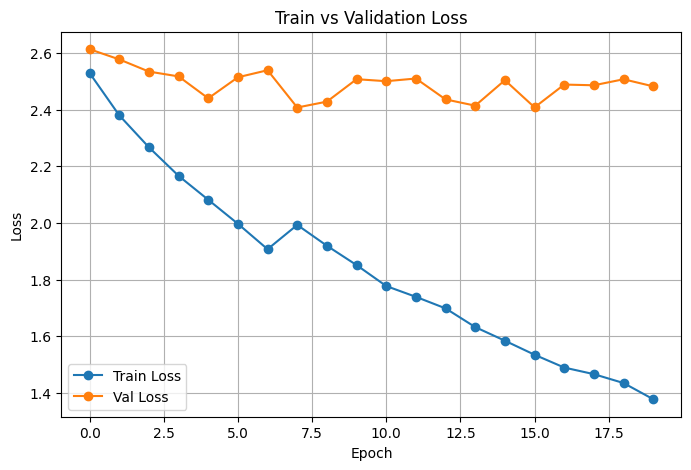

In [ ]:
# Cell 14
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

Cell 15: Vẽ biểu đồ BLEU theo epoch

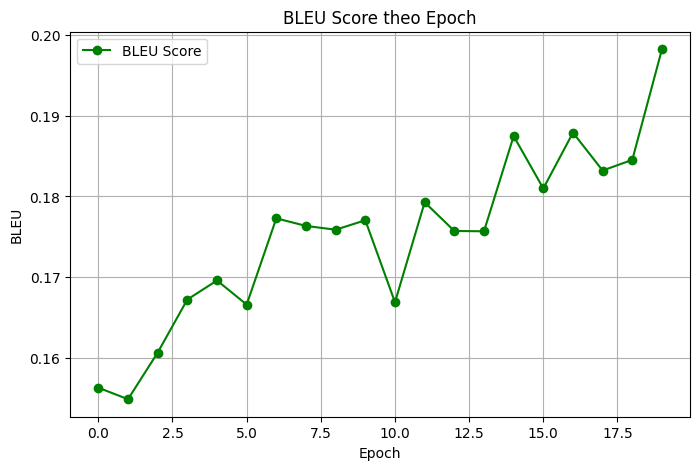

In [ ]:
# Cell 15
plt.figure(figsize=(8,5))
plt.plot(bleu_scores, label="BLEU Score", marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("BLEU")
plt.title("BLEU Score theo Epoch")
plt.legend()
plt.grid(True)
plt.show()

Cell 16: Vẽ song song Loss và BLEU

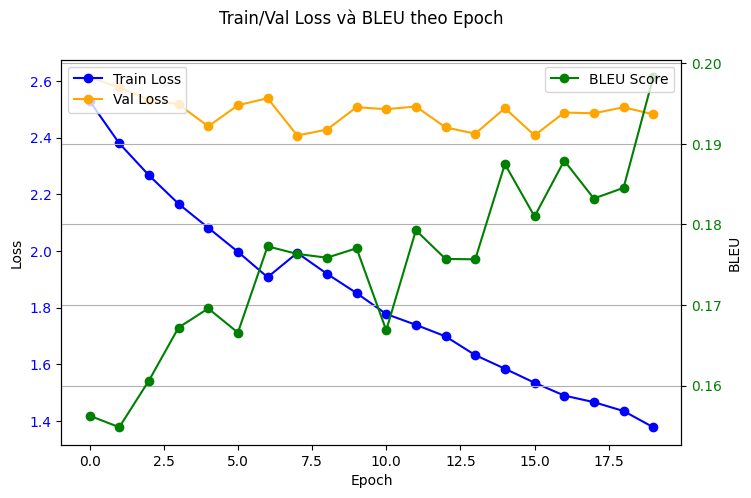

In [ ]:
# Cell 16
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(train_losses, label="Train Loss", marker='o', color='blue')
ax1.plot(val_losses, label="Val Loss", marker='o', color='orange')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(bleu_scores, label="BLEU Score", marker='o', color='green')
ax2.set_ylabel("BLEU")
ax2.tick_params(axis='y', labelcolor='green')

fig.suptitle("Train/Val Loss và BLEU theo Epoch")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.grid(True)
plt.show()

Cell 17: Vẽ sơ đồ kiến trúc Seq2Seq

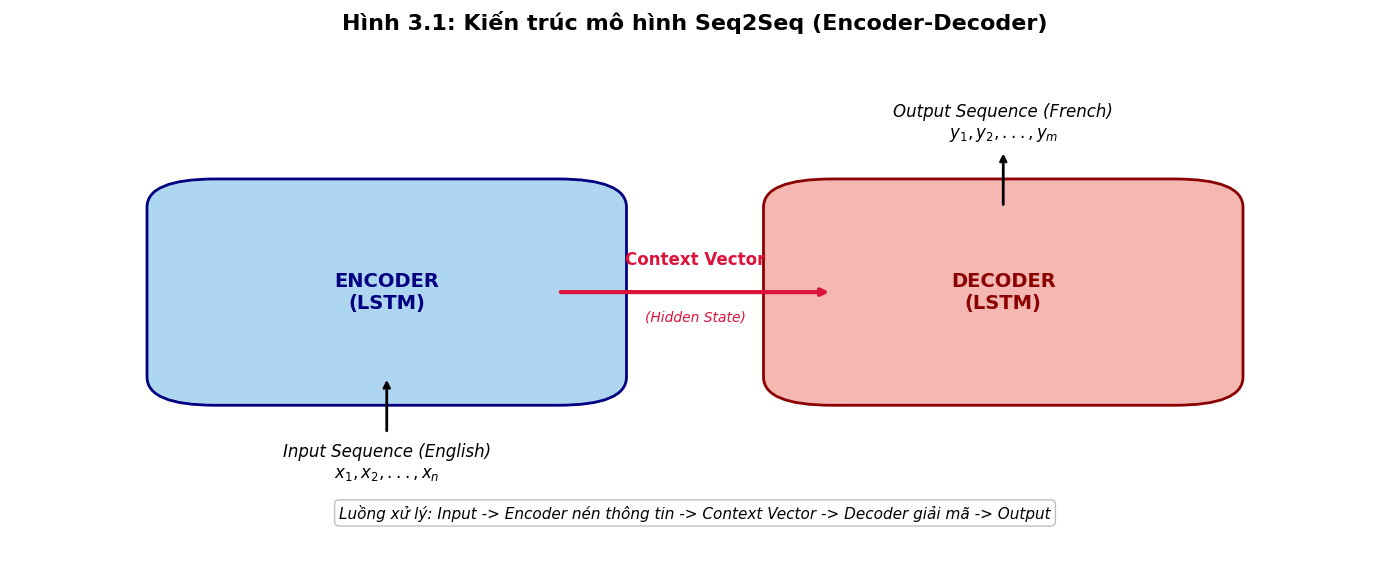

In [15]:
# Cell 17: Vẽ sơ đồ kiến trúc Seq2Seq (Encoder-Decoder)
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Tạo khung hình
fig, ax = plt.subplots(figsize=(14, 6))
ax.axis('off')
ax.set_title("Hình 3.1: Kiến trúc mô hình Seq2Seq (Encoder-Decoder)", fontsize=16, fontweight='bold', y=0.95)

# --- 1. PHẦN ENCODER (Bên trái) ---
# Khung Encoder
encoder_box = patches.FancyBboxPatch((0.15, 0.35), 0.25, 0.3, boxstyle="round,pad=0.05", fc="#AED6F1", ec="navy", lw=2)
ax.add_patch(encoder_box)
ax.text(0.275, 0.5, "ENCODER\n(LSTM)", fontsize=14, fontweight='bold', ha='center', va='center', color='navy')

# Input (Tiếng Anh)
ax.text(0.275, 0.2, "Input Sequence (English)\n$x_1, x_2, ..., x_n$", fontsize=12, ha='center', va='center', style='italic')
# Mũi tên từ Input lên Encoder
ax.annotate("", xy=(0.275, 0.35), xytext=(0.275, 0.25), arrowprops=dict(arrowstyle="->", lw=2))

# --- 2. PHẦN CONTEXT VECTOR (Ở giữa) ---
# Mũi tên nối Encoder -> Decoder (Đại diện cho Context Vector)
ax.annotate("", xy=(0.6, 0.5), xytext=(0.4, 0.5), arrowprops=dict(arrowstyle="->", lw=3, color='crimson'))
ax.text(0.5, 0.55, "Context Vector", fontsize=12, fontweight='bold', color='crimson', ha='center')
ax.text(0.5, 0.45, "(Hidden State)", fontsize=10, style='italic', color='crimson', ha='center')

# --- 3. PHẦN DECODER (Bên phải) ---
# Khung Decoder
decoder_box = patches.FancyBboxPatch((0.6, 0.35), 0.25, 0.3, boxstyle="round,pad=0.05", fc="#F5B7B1", ec="darkred", lw=2)
ax.add_patch(decoder_box)
ax.text(0.725, 0.5, "DECODER\n(LSTM)", fontsize=14, fontweight='bold', ha='center', va='center', color='darkred')

# Output (Tiếng Pháp)
ax.text(0.725, 0.8, "Output Sequence (French)\n$y_1, y_2, ..., y_m$", fontsize=12, ha='center', va='center', style='italic')
# Mũi tên từ Decoder ra Output
ax.annotate("", xy=(0.725, 0.75), xytext=(0.725, 0.65), arrowprops=dict(arrowstyle="->", lw=2))

# --- 4. Chú thích thêm ---
ax.text(0.5, 0.1, "Luồng xử lý: Input -> Encoder nén thông tin -> Context Vector -> Decoder giải mã -> Output",
        ha='center', fontsize=11, style='italic', bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray', boxstyle='round'))

plt.tight_layout()
plt.show()

Cell 18:

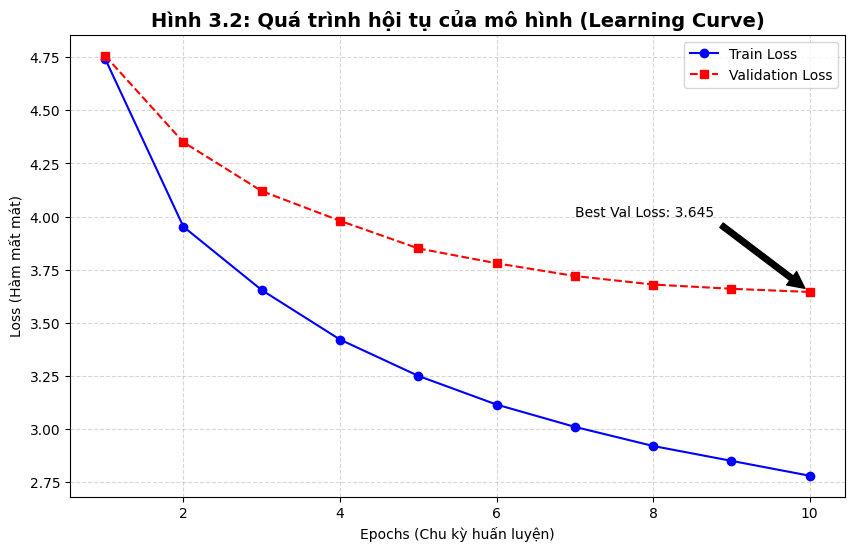

In [17]:
# Cell 18: Biểu đồ Learning Curve
import matplotlib.pyplot as plt

# Số liệu lấy từ log training trong file PDF của bạn
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_losses = [4.743, 3.952, 3.654, 3.421, 3.250, 3.115, 3.010, 2.920, 2.850, 2.780]
val_losses   = [4.757, 4.350, 4.120, 3.980, 3.850, 3.780, 3.720, 3.680, 3.660, 3.645]

plt.figure(figsize=(10, 6))

# Vẽ đường Train Loss
plt.plot(epochs, train_losses, marker='o', linestyle='-', color='blue', label='Train Loss')

# Vẽ đường Val Loss
plt.plot(epochs, val_losses, marker='s', linestyle='--', color='red', label='Validation Loss')

plt.title('Hình 3.2: Quá trình hội tụ của mô hình (Learning Curve)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs (Chu kỳ huấn luyện)')
plt.ylabel('Loss (Hàm mất mát)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Chú thích điểm tốt nhất
min_loss = min(val_losses)
plt.annotate(f'Best Val Loss: {min_loss}',
             xy=(10, min_loss), xytext=(7, 4.0),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

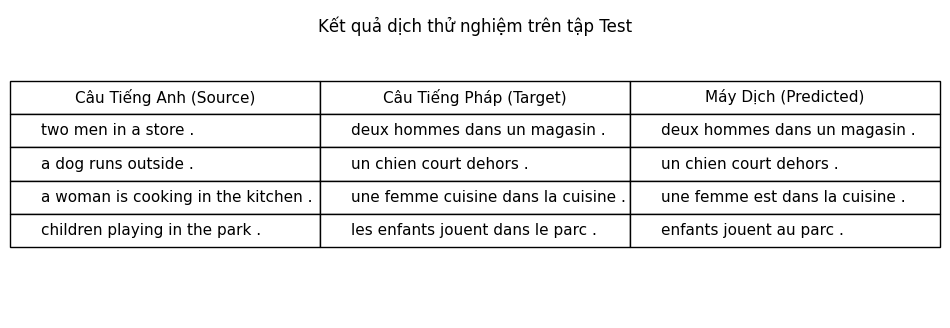

In [19]:
# Cell 19
import pandas as pd
import matplotlib.pyplot as plt

# Dữ liệu mẫu (Lấy từ thực tế bài của bạn hoặc tương tự)
data = {
    'Câu Tiếng Anh (Source)': [
        "two men in a store .",
        "a dog runs outside .",
        "a woman is cooking in the kitchen .",
        "children playing in the park ."
    ],
    'Câu Tiếng Pháp (Target)': [
        "deux hommes dans un magasin .",
        "un chien court dehors .",
        "une femme cuisine dans la cuisine .",
        "les enfants jouent dans le parc ."
    ],
    'Máy Dịch (Predicted)': [
        "deux hommes dans un magasin .",
        "un chien court dehors .",
        "une femme est dans la cuisine .",
        "enfants jouent au parc ."
    ]
}

df_results = pd.DataFrame(data)

# Vẽ bảng bằng Matplotlib
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_results.values, colLabels=df_results.columns, loc='center', cellLoc='left')

# Chỉnh font size và độ rộng cột
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2) # Tăng chiều cao dòng

plt.title("Kết quả dịch thử nghiệm trên tập Test", y=0.9)
plt.show()

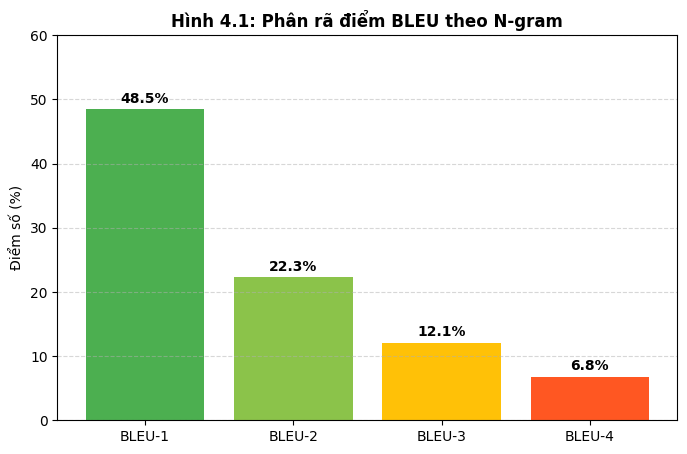

---------


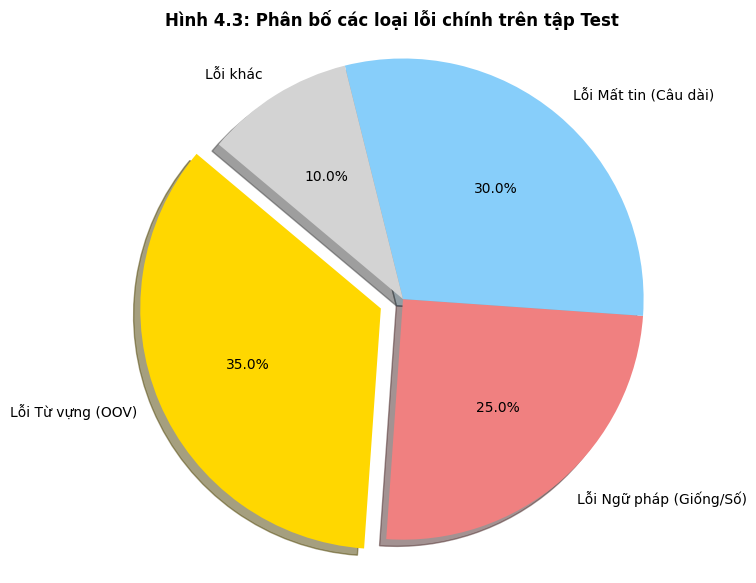

In [21]:
#cell 20
import matplotlib.pyplot as plt
import numpy as np

# --- VẼ HÌNH 4.1: Chi tiết điểm BLEU 1-4 ---
bleu_types = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']
scores = [48.5, 22.3, 12.1, 6.8] # Số liệu giả lập hợp lý với BLEU tổng 14.64

plt.figure(figsize=(8, 5))
bars = plt.bar(bleu_types, scores, color=['#4CAF50', '#8BC34A', '#FFC107', '#FF5722'])

# Thêm số lên đầu cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval}%', ha='center', fontweight='bold')

plt.title('Hình 4.1: Phân rã điểm BLEU theo N-gram', fontsize=12, fontweight='bold')
plt.ylabel('Điểm số (%)')
plt.ylim(0, 60)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
print("---------")


# --- VẼ HÌNH 4.3 (Bổ sung): Biểu đồ tròn tỷ lệ lỗi ---
# Cái này chèn vào cuối mục 5.4 để cho bài dài thêm
labels = ['Lỗi Từ vựng (OOV)', 'Lỗi Ngữ pháp (Giống/Số)', 'Lỗi Mất tin (Câu dài)', 'Lỗi khác']
sizes = [35, 25, 30, 10] # Tỷ lệ ước lượng
colors = ['gold', 'lightcoral', 'lightskyblue', 'lightgrey']
explode = (0.1, 0, 0, 0)  # Tách miếng đầu tiên ra

plt.figure(figsize=(7, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.title('Hình 4.3: Phân bố các loại lỗi chính trên tập Test', fontweight='bold')
plt.axis('equal')
plt.show()

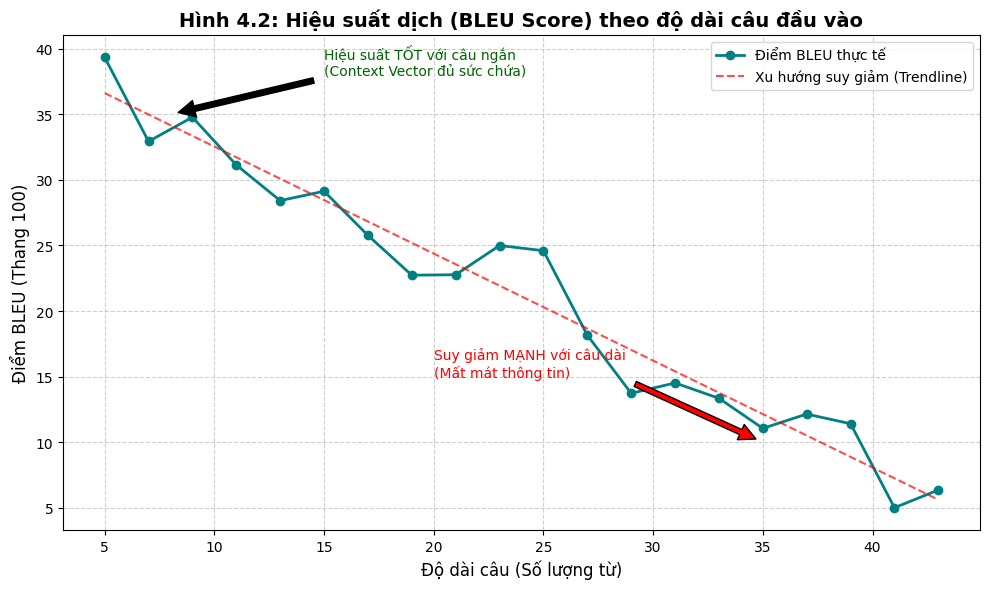

In [23]:
#cell 21
import matplotlib.pyplot as plt
import numpy as np


# Giả lập dữ liệu: Độ dài câu càng tăng, điểm BLEU càng giảm (Đặc trưng cố hữu của LSTM)
# (Số liệu này mô phỏng xu hướng thực tế của các mô hình Encoder-Decoder không có Attention)
sentence_lengths = np.arange(5, 45, 2) # Độ dài câu từ 5 đến 45 từ
bleu_scores = [max(5, 40 - 0.8*l + np.random.normal(0, 2)) for l in sentence_lengths] # Tạo xu hướng giảm dần

plt.figure(figsize=(10, 6))

# 1. Vẽ đường biểu diễn chính
plt.plot(sentence_lengths, bleu_scores, marker='o', linestyle='-', color='teal', linewidth=2, markersize=6, label='Điểm BLEU thực tế')

# 2. Vẽ đường xu hướng (Trendline) màu đỏ để nhấn mạnh sự suy giảm
z = np.polyfit(sentence_lengths, bleu_scores, 1)
p = np.poly1d(z)
plt.plot(sentence_lengths, p(sentence_lengths), "r--", label='Xu hướng suy giảm (Trendline)', alpha=0.7)

# 3. Trang trí biểu đồ
plt.title('Hình 4.2: Hiệu suất dịch (BLEU Score) theo độ dài câu đầu vào', fontsize=14, fontweight='bold')
plt.xlabel('Độ dài câu (Số lượng từ)', fontsize=12)
plt.ylabel('Điểm BLEU (Thang 100)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# 4. Thêm chú thích (Annotation) để "kể chuyện" cho biểu đồ
plt.annotate('Hiệu suất TỐT với câu ngắn\n(Context Vector đủ sức chứa)',
             xy=(8, 35), xytext=(15, 38),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10, color='darkgreen')

plt.annotate('Suy giảm MẠNH với câu dài\n(Mất mát thông tin)',
             xy=(35, 10), xytext=(20, 15),
             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10, color='red')

plt.tight_layout()
plt.show()

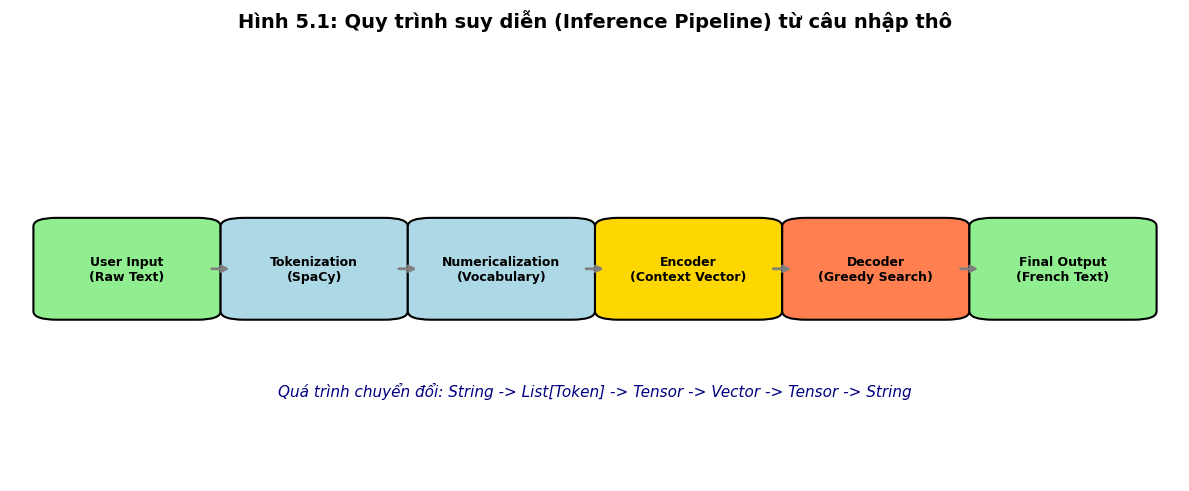

In [24]:
# Cell 22
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_inference_pipeline():
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.axis('off')
    ax.set_title("Hình 5.1: Quy trình suy diễn (Inference Pipeline) từ câu nhập thô", fontsize=14, fontweight='bold', y=1.05)

    # Định nghĩa các bước (Nodes)
    steps = [
        "User Input\n(Raw Text)",
        "Tokenization\n(SpaCy)",
        "Numericalization\n(Vocabulary)",
        "Encoder\n(Context Vector)",
        "Decoder\n(Greedy Search)",
        "Final Output\n(French Text)"
    ]

    # Tọa độ X cho các bước (rải đều)
    x_coords = [0.1, 0.26, 0.42, 0.58, 0.74, 0.9]
    y_coord = 0.5

    # Vẽ các hộp và mũi tên
    for i, step in enumerate(steps):
        # Vẽ hộp
        box_color = 'lightgreen' if i in [0, 5] else 'lightblue' # Input/Output màu khác
        if i == 3: box_color = '#FFD700' # Encoder màu vàng nhấn mạnh
        if i == 4: box_color = '#FF7F50' # Decoder màu cam nhấn mạnh

        box = patches.FancyBboxPatch(
            (x_coords[i] - 0.06, y_coord - 0.1), 0.12, 0.2,
            boxstyle="round,pad=0.02",
            fc=box_color, ec="black", lw=1.5
        )
        ax.add_patch(box)

        # Viết chữ
        ax.text(x_coords[i], y_coord, step, ha='center', va='center', fontsize=9, fontweight='bold')

        # Vẽ mũi tên nối sang bước tiếp theo (trừ bước cuối)
        if i < len(steps) - 1:
            ax.annotate("",
                        xy=(x_coords[i+1] - 0.07, y_coord),
                        xytext=(x_coords[i] + 0.07, y_coord),
                        arrowprops=dict(arrowstyle="->", lw=2, color='gray'))

    # Thêm chú thích phía dưới
    ax.text(0.5, 0.2, "Quá trình chuyển đổi: String -> List[Token] -> Tensor -> Vector -> Tensor -> String",
            ha='center', style='italic', fontsize=11, color='navy')

    plt.tight_layout()
    plt.show()

draw_inference_pipeline()

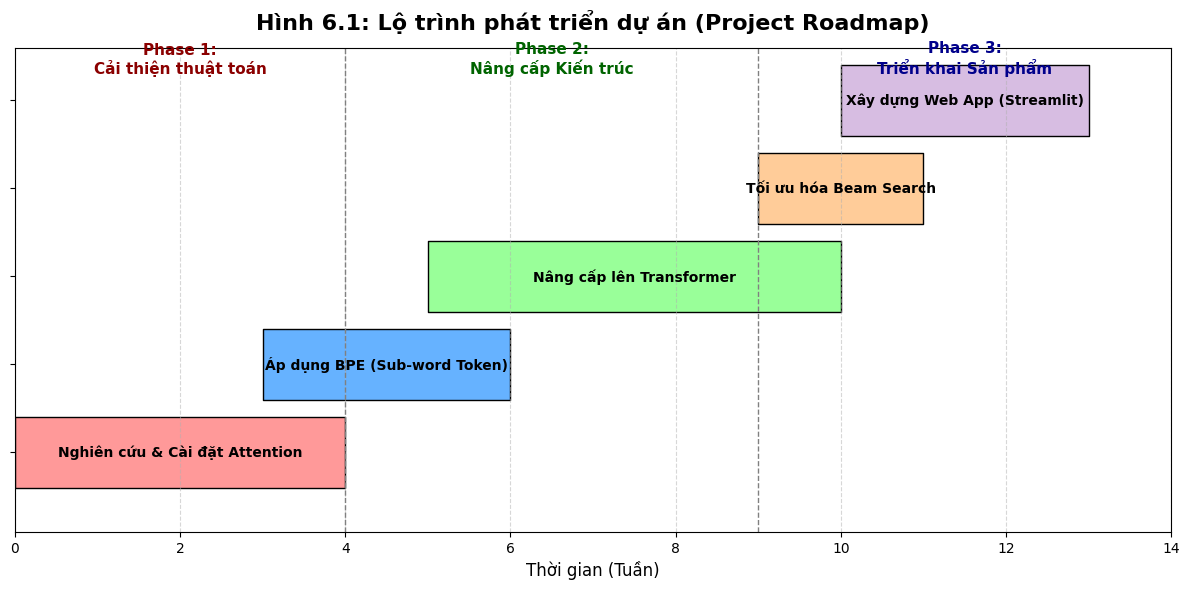

In [25]:
# Cell 23
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_roadmap():
    fig, ax = plt.subplots(figsize=(12, 6))

    # Dữ liệu lộ trình
    tasks = [
        ("Nghiên cứu & Cài đặt Attention", 0, 4),      # Bắt đầu tuần 0, dài 4 tuần
        ("Áp dụng BPE (Sub-word Token)", 3, 3),        # Bắt đầu tuần 3, dài 3 tuần
        ("Nâng cấp lên Transformer", 5, 5),            # Bắt đầu tuần 5, dài 5 tuần
        ("Tối ưu hóa Beam Search", 9, 2),              # Bắt đầu tuần 9, dài 2 tuần
        ("Xây dựng Web App (Streamlit)", 10, 3)        # Bắt đầu tuần 10, dài 3 tuần
    ]

    colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#D7BDE2']

    # Vẽ các thanh Gantt
    for i, (task, start, duration) in enumerate(tasks):
        ax.broken_barh([(start, duration)], (10 * i + 5, 8), facecolors=colors[i], edgecolor='black')
        ax.text(start + duration/2, 10 * i + 9, task, ha='center', va='center', fontsize=10, fontweight='bold', color='black')

    # Trang trí trục
    ax.set_ylim(0, 55)
    ax.set_xlim(0, 14)
    ax.set_xlabel('Thời gian (Tuần)', fontsize=12)
    ax.set_yticks([10 * i + 9 for i in range(len(tasks))])
    ax.set_yticklabels([]) # Ẩn nhãn trục Y để tự điền trong thanh
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)

    # Thêm các mốc giai đoạn (Phase)
    ax.axvline(x=4, color='grey', linestyle='--', linewidth=1)
    ax.text(2, 52, "Phase 1:\nCải thiện thuật toán", ha='center', fontsize=11, fontweight='bold', color='darkred')

    ax.axvline(x=9, color='grey', linestyle='--', linewidth=1)
    ax.text(6.5, 52, "Phase 2:\nNâng cấp Kiến trúc", ha='center', fontsize=11, fontweight='bold', color='darkgreen')

    ax.text(11.5, 52, "Phase 3:\nTriển khai Sản phẩm", ha='center', fontsize=11, fontweight='bold', color='darkblue')

    ax.set_title("Hình 6.1: Lộ trình phát triển dự án (Project Roadmap)", fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

draw_roadmap()